# Exploratory DIA analysis
### Ira Horecka, Winter 2022, Hannes Roest

## As stated in rotation README by Hannes:
For Ira's Rotation project Hannes is interested in mapping the raw data in a DIA run OSW results. 


1. How much of the raw data is currently explained by the OSW features
2. Is the raw data "used twice" 
    - One raw data is mapped to multiple library entries 

Also look at this on the MS1 level. 

In [2]:
import os

import pandas as pd
import pyopenms as pms

BASE_DIR = os.path.dirname(os.path.realpath("__file__"))
DATA_DIR = os.path.join(BASE_DIR, "data")


Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [3]:
# Read 2400-2700 RT window SWATH file - format TSV
swath_tsv_path = os.path.join(DATA_DIR, "run_1330_0_pyprophet_output_2400_2700_RT_700Swath.tsv")
swath_tsv = pd.read_csv(swath_tsv_path, sep="\t")
swath_tsv.head()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/irahorecka/Desktop/Harddrive_Desktop/PhD/University of Toronto/Rotations/Rost Lab/roest-ms/data/run_1330_0_pyprophet_output_2400_2700_RT_700Swath.tsv'

In [4]:
# Read corresponding mzML file and load it into pyopenms object
swath_exp = pms.MSExperiment()
swath_mzml_path = os.path.join(
    DATA_DIR,
    "mzML",
    "Rost_DIApy3_SP2um_90min_250ngK562_100nL_1_Slot1-5_1_1330_6-28-2021_0_2400_to_2700_swath_700.mzML",
)

pms.MzMLFile().load(swath_mzml_path, swath_exp)


## Loading demo mzML file to TOPPView - observations
mzML relative filepath: ./data/mzML/Rost_DIApy3_SP2um_90min_250ngK562_100nL_1_Slot1-5_1_1330_6-28-2021_0_2400_to_2700_swath_700.mzML

Observations:
    
    - 168 total indices range(168)
    - Each index usually has an outstanding peak @ 712.5 m/z, with many subtler peaks on either side
    - RT window of 2400 - 2700
    - TOPPView shows only MS2 spectra
    
As an exercise, extract features observed in TOPPView using `pyopenms`

In [121]:
# Get total spectra count
print("Total spectra:", swath_exp.getNrSpectra())

# Count number of unique MS levels in spectra
from collections import Counter

swath_ms_levels = [spect.getMSLevel() for spect in swath_exp]
print("MS levels for all spectra:", dict(Counter(swath_ms_levels)))


Total spectra: 168
MS levels for all spectra: {2: 168}


In [122]:
# Continue data discovery
demo = swath_exp[1]
mz, intensity = demo.get_peaks()
# Max intensities found per spectrum
max_intensities = []

for idx, spec in enumerate(swath_exp):
    mz, intensity = spec.get_peaks()
    # Get maximum intensity of each spectrum
    max_intensities.append(max(list(zip(intensity, mz))))

# Print grouped m/z count for max intensity - most should lie around ~710 m/z
mz_max_intensities = dict(Counter([int(i[1]) for i in max_intensities]))
print(
    "Most common m/z values in max intensity spectrum:",
    sorted(mz_max_intensities.items(), key=lambda x: x[1], reverse=True),
)
# Check RT range is between 2400-2700 m/z
rt = [spec.getRT() for spec in swath_exp]
print("RT range:", min(rt), max(rt))


Most common m/z values in max intensity spectrum: [(705, 19), (713, 16), (720, 16), (709, 15), (711, 10), (820, 9), (710, 8), (718, 5), (708, 5), (701, 5), (702, 5), (912, 4), (815, 4), (834, 4), (804, 3), (651, 3), (637, 3), (877, 3), (890, 3), (567, 3), (847, 2), (727, 2), (800, 2), (707, 2), (700, 2), (867, 2), (717, 2), (909, 1), (958, 1), (699, 1), (706, 1), (776, 1), (746, 1), (724, 1), (574, 1), (976, 1), (1019, 1), (716, 1)]
RT range: 2400.240718 2699.343844


## Working with Josh in exploring mzML file

Required files

    - run_1330_0_pyprophet_output_2400_2700_RT_700Swath.tsv
        Cols of interest:
        - m_score (corrected q_value - q<0.01 is considered significant)
        - peak_group
        - RT_leftWidth
        - RT_rightWidth
        - mz
        - assay_RT
        - IM
        - delta IM
    - merged_-1.osw
        Tables of interest:
        - feature_transition
        - transition_id

In [122]:
# 'run_1330_0_pyprophet_output_2400_2700_RT_700Swath.tsv' is already loaded in `swath_tsv`
# as a pandas dataframe
swath_tsv.shape


(3210, 28)

In [123]:
swath_tsv.head()


,id_run,id_peptide,transition_group_id,decoy,run_id,filename,RT,assay_rt,delta_rt,iRT,...,Charge,mz,Intensity,aggr_prec_Peak_Area,aggr_prec_Peak_Apex,RT_leftWidth,RT_rightWidth,peak_group_rank,d_score,m_score
0,-3635800775910245364,168629,571,0,-3635800775910245364,../../../2021-09-16-CalibratedLibraryPy3/mzml/...,2697.96,2788.883056,-90.923056,40.189148,...,2,712.8859,2968.01,1823.356445,533.672064,2690.414062,2699.343750,2.0,0.854111,0.068830
1,-3635800775910245364,7482,830,0,-3635800775910245364,../../../2021-09-16-CalibratedLibraryPy3/mzml/...,2609.32,2444.188210,165.131790,38.788108,...,2,723.3385,2154.01,17603.246094,3834.683030,2600.658691,2611.462891,1.0,-0.082185,0.159605
2,-3635800775910245364,7482,830,0,-3635800775910245364,../../../2021-09-16-CalibratedLibraryPy3/mzml/...,2416.66,2444.187681,-27.527681,35.613998,...,2,723.3385,3120.01,32910.914062,9055.394695,2403.811279,2423.454834,2.0,-0.597191,0.210172
3,-3635800775910245364,7482,830,0,-3635800775910245364,../../../2021-09-16-CalibratedLibraryPy3/mzml/...,2581.07,2444.187480,136.882520,38.319273,...,2,723.3385,3311.01,5678.909668,1176.703051,2579.069580,2589.849609,3.0,-1.592275,0.261939
4,-3635800775910245364,7482,830,0,-3635800775910245364,../../../2021-09-16-CalibratedLibraryPy3/mzml/...,2678.77,2444.185922,234.584078,39.860776,...,2,723.3385,3977.00,17530.015625,3289.267249,2676.129395,2690.414062,5.0,-1.615050,0.262411


In [124]:
# Get swath_tsv where `m_score` is < 0.01
sig_swath_tsv = swath_tsv[swath_tsv["m_score"] < 0.01]

# What percent are sig?
print(f"% significant transitions: {round(sig_swath_tsv.shape[0] / swath_tsv.shape[0], 3) * 100}%")


% significant transitions: 8.6%


In [125]:
# Declare columns of interest
cols_interest = [
    "id_run",
    "id_peptide",
    "transition_group_id",
    "peak_group_rank",
    "RT_leftWidth",
    "RT_rightWidth",
    "mz",
    "assay_rt",
    "IM",
    "delta_im",
    "m_score",
]
sig_swath_tsv[cols_interest].head(20)


,id_run,id_peptide,transition_group_id,peak_group_rank,RT_leftWidth,RT_rightWidth,mz,assay_rt,IM,delta_im,m_score
13,-3635800775910245364,90813,2067,1.0,2622.177490,2649.336182,719.8805,2675.581879,1.050059,-0.003509,0.000649
16,-3635800775910245364,168815,2315,1.0,2532.495361,2555.746338,720.3578,2502.000500,0.953968,-0.003532,0.000015
19,-3635800775910245364,91690,2854,1.0,2473.461914,2489.545654,724.3661,2431.406177,1.037768,-0.004482,0.000008
20,-3635800775910245364,91690,2854,2.0,2443.097168,2462.740479,724.3661,2431.403258,1.027409,-0.014841,0.008254
25,-3635800775910245364,92083,3265,1.0,2672.557129,2688.630127,709.3381,2715.605607,0.951570,0.026874,0.000008
37,-3635800775910245364,94223,5384,1.0,2443.097168,2462.740479,715.3588,2145.316635,1.066235,-0.000008,0.000654
38,-3635800775910245364,94423,5578,1.0,2443.097168,2464.525391,707.3614,2462.982534,1.072348,0.004522,0.000002
41,-3635800775910245364,94733,5820,1.0,2493.121094,2518.155762,709.3621,2586.040058,1.013508,-0.003598,0.000002
43,-3635800775910245364,94992,6012,1.0,2575.497803,2604.229736,707.3646,2683.835965,1.013300,0.005641,0.000009
45,-3635800775910245364,95023,6036,1.0,2469.889893,2498.479980,708.8701,2524.182185,1.020349,-0.015464,0.000015


In [126]:
swath_tsv[cols_interest].head(20)


,id_run,id_peptide,transition_group_id,peak_group_rank,RT_leftWidth,RT_rightWidth,mz,assay_rt,IM,delta_im,m_score
0,-3635800775910245364,168629,571,2.0,2690.414062,2699.343750,712.8859,2788.883056,1.015006,-0.010396,0.068830
1,-3635800775910245364,7482,830,1.0,2600.658691,2611.462891,723.3385,2444.188210,1.012386,-0.017635,0.159605
2,-3635800775910245364,7482,830,2.0,2403.811279,2423.454834,723.3385,2444.187681,1.028506,-0.001516,0.210172
3,-3635800775910245364,7482,830,3.0,2579.069580,2589.849609,723.3385,2444.187480,1.020140,-0.009882,0.261939
4,-3635800775910245364,7482,830,5.0,2676.129395,2690.414062,723.3385,2444.185922,1.028736,-0.001285,0.262411
5,-3635800775910245364,7483,854,1.0,2503.837158,2521.761719,723.3385,2573.580361,1.046688,-0.018026,0.158007
6,-3635800775910245364,7483,854,2.0,2394.884521,2402.026123,723.3385,2573.581698,1.045929,-0.018785,0.186453
7,-3635800775910245364,7483,854,4.0,2448.454346,2464.525391,723.3385,2573.575988,1.044717,-0.019997,0.240230
8,-3635800775910245364,89733,1102,2.0,2460.954346,2469.889893,720.3624,2334.965866,0.957702,0.025701,0.103825
9,-3635800775910245364,89733,1102,4.0,2428.811768,2441.311768,720.3624,2334.960156,0.959442,0.027441,0.264220


## Investigative work - starting small
Task
- Isolate one spectrum using `pyopenms`
    - Isolate all precursors in that spectrum using RT on `.osw` file
    - See how many raw signals do not correspond with any precursor

In [250]:
# Get 101 spectrum
demo_spec = swath_exp[0]
# Get m/z and intensity
mz, intensity = demo_spec.get_peaks()
print("m/z:", mz)
print("intensity:", intensity)
print("data len:", len(mz))


m/z: [ 135.7740564   144.03432893  176.29239387 ... 1654.64611591 1688.79344964
 1698.72259212]
intensity: [10.000413 10.000413 10.000413 ... 10.000413 48.999626 10.000413]
data len: 23356


In [251]:
# More spectrum attributes
print("RT:", demo_spec.getRT())
precs = [prec.getMZ() for prec in demo_spec.getPrecursors()]
print("Precursors:", precs)
print("Max intensity m/z:", mz[list(intensity).index(max(intensity))])


RT: 2400.240718
Precursors: [712.5]
Max intensity m/z: 711.8682341745807


In [252]:
demo_spec_im = demo_spec.getFloatDataArrays()[0].get_data()
print("MZ data len:", len(mz))
print("Intensity data len:", len(intensity))
print("IM data len:", len(demo_spec_im))
mz_i_im = zip(mz, intensity, demo_spec_im)
print(list(mz_i_im)[0])


MZ data len: 23356
Intensity data len: 23356
IM data len: 23356
(135.77405639857363, 10.000413, 1.0762253)


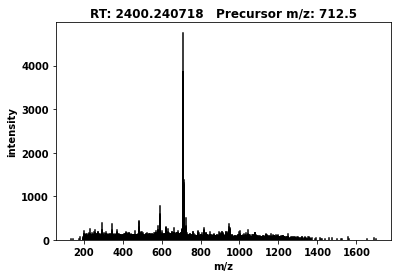

In [253]:
import matplotlib.pyplot as plt


def plot_spectrum(spectrum):
    # plot every peak in spectrum and annotate with it's m/z
    for mz, i in zip(*spectrum.get_peaks()):
        plt.plot([mz, mz], [0, i], color="black")
        # plt.text(mz, i, str(mz))

    # for the title add RT and Precursor m/z if available
    title = ""
    if spectrum.getRT() >= 0:
        title += "RT: " + str(spectrum.getRT())
    if len(spectrum.getPrecursors()) >= 1:
        title += "   Precursor m/z: " + str(spectrum.getPrecursors()[0].getMZ())

    plt.title(title)
    plt.ylabel("intensity")
    plt.xlabel("m/z")
    plt.ylim(bottom=0)

    plt.show()


# plotting out spectrum that was defined earlier
plot_spectrum(demo_spec)


In [178]:
# Explore methods of a spectrum object
get_methods = [method for method in dir(demo_spec) if method.startswith("get")]
for method in get_methods:
    try:
        print(f"demo_spec.{method}()")
        print(eval(f"demo_spec.{method}()"))
        print("--------------")
    except:
        pass


demo_spec.getAcquisitionInfo()
--------------
demo_spec.getComment()

--------------
demo_spec.getDataProcessing()
--------------
demo_spec.getDriftTime()
-1.0
--------------
demo_spec.getFloatDataArrays()
--------------
demo_spec.getInstrumentSettings()
--------------
demo_spec.getIntegerDataArrays()
[]
--------------
demo_spec.getKeys()
demo_spec.getMSLevel()
2
--------------
demo_spec.getMax()
--------------
demo_spec.getMaxInt()
-1.7976931348623157e+308
--------------
demo_spec.getMetaValue()
demo_spec.getMin()
--------------
demo_spec.getMinInt()
1.7976931348623157e+308
--------------
demo_spec.getName()

--------------
demo_spec.getNativeID()
frame=24486_scan=452
--------------
demo_spec.getPeptideIdentifications()
[]
--------------
demo_spec.getPrecursors()
--------------
demo_spec.getProducts()
[]
--------------
demo_spec.getRT()
2579.0696
--------------
demo_spec.getSourceFile()
--------------
demo_spec.getStringDataArrays()
[]
--------------
demo_spec.getType()
0
------------

In [192]:
# Explore precursors derived from the getPrecursor method
prec_methods = [prec for prec in dir(demo_spec.getPrecursors()[0]) if prec.startswith("get")]
prec_spec = demo_spec.getPrecursors()[0]
for method in prec_methods:
    try:
        print(f"prec_spec.{method}()")
        print(eval(f"prec_spec.{method}()"))
        print("--------------")
    except:
        pass


prec_spec.getActivationEnergy()
0.0
--------------
prec_spec.getActivationMethods()
set()
--------------
prec_spec.getCVTerms()
{}
--------------
prec_spec.getCharge()
0
--------------
prec_spec.getDriftTime()
-1.0
--------------
prec_spec.getDriftTimeWindowLowerOffset()
0.0
--------------
prec_spec.getDriftTimeWindowUpperOffset()
0.0
--------------
prec_spec.getIntensity()
0.0
--------------
prec_spec.getIsolationWindowLowerOffset()
12.5
--------------
prec_spec.getIsolationWindowUpperOffset()
12.5
--------------
prec_spec.getKeys()
prec_spec.getMZ()
712.5
--------------
prec_spec.getMetaValue()
prec_spec.getPos()
712.5
--------------
prec_spec.getPossibleChargeStates()
[]
--------------
prec_spec.getUnchargedMass()
1422.985447066458
--------------


## Exploring .osw (OpenSWATH)

In [57]:
import os
import sqlite3

import pandas as pd


def generate_tables():
    with sqlite3.connect(os.path.join(DATA_DIR, "osw", "merged_-1.osw")) as con:
        cur = con.cursor()
        cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cur.fetchall()
        feature_ms2_table_name = "FEATURE_MS2"
        score_ms2_table_name = "SCORE_MS2"
        feature_trans_table_name = "FEATURE_TRANSITION"
        feature_ms2_table = pd.read_sql_query(
            "SELECT * from %s" % feature_ms2_table_name, con, chunksize=10_000
        )
        score_ms2_table = pd.read_sql_query(
            "SELECT * from %s" % score_ms2_table_name, con, chunksize=10_000
        )
        feature_trans_table = pd.read_sql_query(
            "SELECT * from %s" % feature_trans_table_name, con, chunksize=10_000
        )
    return score_ms2_table, feature_ms2_table, feature_trans_table


score_ms2_table, feature_ms2_table, feature_trans_table = generate_tables()


In [54]:
# Parallelize apply func - works but niche

from pandarallel import pandarallel

pandarallel.initialize()


score_ms2_table, _, _ = generate_tables()
df = pd.concat(next(score_ms2_table) for _ in range(50))
df[df.parallel_apply(lambda x: x["QVALUE"] < 0.01, axis=1)]


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,FEATURE_ID,SCORE,RANK,PVALUE,QVALUE,PEP
2,-6911607367913509504,5.565315,1.0,0.000002,0.000002,0.000004
6,-2481314218077951340,2.418058,1.0,0.012299,0.005370,0.094519
13,5380633255937568871,6.240179,1.0,0.000002,0.000002,0.000004
15,4870883581719333282,5.089730,2.0,0.000008,0.000006,0.000022
17,2662013945061609836,5.028170,3.0,0.000012,0.000008,0.000042
...,...,...,...,...,...,...
9978,2154592232806935649,2.203886,1.0,0.019331,0.008224,0.139059
9984,5551075725400963568,5.712923,1.0,0.000002,0.000002,0.000004
9990,-3364692471946789735,4.811976,1.0,0.000012,0.000008,0.000042
9995,4311783229278480081,4.436841,1.0,0.000052,0.000031,0.000355


['FEATURE_ID',
 'AREA_INTENSITY',
 'TOTAL_AREA_INTENSITY',
 'APEX_INTENSITY',
 'TOTAL_MI',
 'VAR_BSERIES_SCORE',
 'VAR_DOTPROD_SCORE',
 'VAR_INTENSITY_SCORE',
 'VAR_ISOTOPE_CORRELATION_SCORE',
 'VAR_ISOTOPE_OVERLAP_SCORE',
 'VAR_LIBRARY_CORR',
 'VAR_LIBRARY_DOTPROD',
 'VAR_LIBRARY_MANHATTAN',
 'VAR_LIBRARY_RMSD',
 'VAR_LIBRARY_ROOTMEANSQUARE',
 'VAR_LIBRARY_SANGLE',
 'VAR_LOG_SN_SCORE',
 'VAR_MANHATTAN_SCORE',
 'VAR_MASSDEV_SCORE',
 'VAR_MASSDEV_SCORE_WEIGHTED',
 'VAR_MI_SCORE',
 'VAR_MI_WEIGHTED_SCORE',
 'VAR_MI_RATIO_SCORE',
 'VAR_NORM_RT_SCORE',
 'VAR_XCORR_COELUTION',
 'VAR_XCORR_COELUTION_WEIGHTED',
 'VAR_XCORR_SHAPE',
 'VAR_XCORR_SHAPE_WEIGHTED',
 'VAR_YSERIES_SCORE',
 'VAR_ELUTION_MODEL_FIT_SCORE',
 'VAR_IM_XCORR_SHAPE',
 'VAR_IM_XCORR_COELUTION',
 'VAR_IM_DELTA_SCORE',
 'VAR_SONAR_LAG',
 'VAR_SONAR_SHAPE',
 'VAR_SONAR_LOG_SN',
 'VAR_SONAR_LOG_DIFF',
 'VAR_SONAR_LOG_TREND',
 'VAR_SONAR_RSQ']

In [85]:
# SCORE_MS2_TABLE AND FEATURE_TABLE DO NOT HAVE MATCHING IDS
def merge_on_col(df1, df2, col):
    return df1.merge(df2, on=col)


# score_ms2_table = next(score_ms2_table).rename(columns={"FEATURE_ID":"ID"})
# merge_on_col(next(feature_table), score_ms2_table, 'ID')


In [79]:
# Get significant ms2 score featues using a Qval cutoff of 0.01
score_ms2_table, _ = generate_tables()
cutoff_qval = 0.01
score_ms2_colnames = ["FEATURE_ID", "SCORE", "RANK", "PVALUE", "QVALUE", "PEP"]
score_ms2_sig_table = pd.DataFrame(columns=list(score_ms2_colnames))
for chunk in score_ms2_table:
    score_ms2_sig_table = score_ms2_sig_table.append(chunk[chunk["QVALUE"] < cutoff_qval])
score_ms2_sig_table.to_csv(
    os.path.join(DATA_DIR, "20220119_sig_ms2_score.tsv"), sep="\t", index=False
)


In [81]:
score_ms2_sig_table = pd.read_csv(os.path.join(DATA_DIR, "20220119_sig_ms2_score.tsv"), sep="\t")
score_ms2_sig_table.head()


,FEATURE_ID,SCORE,RANK,PVALUE,QVALUE,PEP
0,-6911607367913509504,5.565315,1.0,0.000002,0.000002,0.000004
1,-2481314218077951340,2.418058,1.0,0.012299,0.005370,0.094519
2,5380633255937568871,6.240179,1.0,0.000002,0.000002,0.000004
3,4870883581719333282,5.089730,2.0,0.000008,0.000006,0.000022
4,2662013945061609836,5.028170,3.0,0.000012,0.000008,0.000042


In [180]:
def get_empty_df_from_merged_df(df1, df2, key, nullify_obj=True):
    if nullify_obj:
        df1 = df1.select_dtypes(exclude=["object"])
        df2 = df2.select_dtypes(exclude=["object"])
    colnames = list(merge_on_col(df1, df2, key))
    return pd.DataFrame(columns=colnames)


get_empty_df_from_merged_df(score_ms2_sig_table, next(feature_ms2_table), "FEATURE_ID")


In [196]:
# Link significant ms2 features using a Qval cutoff of 0.01 TO feature_ms2
# PART 1/2
# JOIN ON COL 'FEATURE_ID'
# DATA GENERATED: 2022-01-19 21:00
# NOTE: FEATURE_MS2 TABLE JOIN MIGHT BE USELESS, BUT IT IS INOCUOUS
import numpy as np

_, feature_ms2_table, _ = generate_tables()
merged_feature_ms2_df = get_empty_df_from_merged_df(
    score_ms2_sig_table, next(feature_ms2_table), "FEATURE_ID"
)
# reset generator
_, feature_ms2_table, _ = generate_tables()

for table_ms2 in feature_ms2_table:
    feature_ms2_chunk = table_ms2.select_dtypes(exclude=["object"])
    merged_feature_ms2_df = merged_feature_ms2_df.append(
        merge_on_col(score_ms2_sig_table, feature_ms2_chunk, "FEATURE_ID")
    )

output_merged_ms2_sigscore_feature_tsv = os.path.join(
    DATA_DIR, "20220119_merged_ms2_sigscore_and_feature.tsv"
)
merged_feature_ms2_df.to_csv(output_merged_ms2_sigscore_feature_tsv, sep="\t", index=False)


In [193]:
# Link significant ms2 features using a Qval cutoff of 0.01 TO feature_trans
# PART 2/2
# JOIN ON COL 'FEATURE_ID'
# DATA GENERATED: 2022-01-19 21:00
import numpy as np

_, _, feature_trans_table = generate_tables()
merged_trans_ms2_df = get_empty_df_from_merged_df(
    score_ms2_sig_table, next(feature_trans_table), "FEATURE_ID"
)
# reset generator
_, _, feature_trans_table = generate_tables()

for table_trans in feature_trans_table:
    feature_trans_chunk = table_trans.select_dtypes(exclude=["object"])
    merged_trans_ms2_df = merged_trans_ms2_df.append(
        merge_on_col(score_ms2_sig_table, feature_trans_chunk, "FEATURE_ID")
    )

output_merged_ms2_sigscore_feature_trans_tsv = os.path.join(
    DATA_DIR, "20220119_merged_ms2_sigscore_and_feature_trans.tsv"
)
merged_trans_ms2_df.to_csv(output_merged_ms2_sigscore_feature_trans_tsv, sep="\t", index=False)


NameError: name 'score_ms2_signal' is not defined

In [198]:
merged_feature_ms2_df_from_tsv = pd.read_csv(output_merged_ms2_sigscore_feature_tsv, sep="\t")
merged_feature_trans_ms2_df_from_tsv = pd.read_csv(
    output_merged_ms2_sigscore_feature_trans_tsv, sep="\t"
)


In [305]:
# NOW LINK PART 1/2 WITH PART 2/2
print(merged_feature_ms2_df_from_tsv.shape)
print(merged_feature_trans_ms2_df_from_tsv.shape)
merged_ms2_score_feature_trans_df = merge_on_col(
    merged_feature_ms2_df_from_tsv, merged_feature_trans_ms2_df_from_tsv, "FEATURE_ID"
)
print(merged_ms2_score_feature_trans_df.shape)


(432402, 33)
(2594412, 10)
(2594412, 42)


In [310]:
# Get left width and right width using FEATURE table
import os
import sqlite3

import pandas as pd


def get_feature_table():
    with sqlite3.connect(os.path.join(DATA_DIR, "osw", "merged_-1.osw")) as con:
        cur = con.cursor()
        cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
        feature_table_name = "FEATURE"
        feature_table = pd.read_sql_query(
            "SELECT * from %s" % feature_table_name, con, chunksize=10_000
        )
    return feature_table


feature_table = next(get_feature_table()).rename(columns={"ID": "FEATURE_ID"})
merged_ms2_score_feature_trans_df_1 = get_empty_df_from_merged_df(
    merged_ms2_score_feature_trans_df, feature_table, "FEATURE_ID"
)
feature_tables = get_feature_table()
for feature_table in feature_tables:
    feature_table = feature_table.rename(columns={"ID": "FEATURE_ID"})
    merged = merge_on_col(merged_ms2_score_feature_trans_df, feature_table, "FEATURE_ID")
    merged_ms2_score_feature_trans_df_1 = merged_ms2_score_feature_trans_df_1.append(merged)

merged_ms2_score_feature_trans_df_1_tsv = os.path.join(
    DATA_DIR, "20220120_merged_ms2_sigscore_feature_transition_left_right.tsv"
)
merged_ms2_score_feature_trans_df_1.to_csv(
    merged_ms2_score_feature_trans_df_1_tsv, sep="\t", index=False
)


In [371]:
temp = merged_ms2_score_feature_trans_df_1
temp["TRANSITION_ID"] = pd.to_numeric(temp["TRANSITION_ID"])


In [372]:
"TRANSITION_ID" in list(temp)


True

In [373]:
def get_trans_table():
    with sqlite3.connect(os.path.join(DATA_DIR, "osw", "merged_-1.osw")) as con:
        cur = con.cursor()
        cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
        trans_table_name = "TRANSITION"
        trans_table = pd.read_sql_query(
            "SELECT * from %s" % trans_table_name, con, chunksize=10_000
        )
    return trans_table


trans_table = next(get_trans_table()).rename(columns={"ID": "TRANSITION_ID"})
concat_trans_file = get_empty_df_from_merged_df(temp, trans_table, "TRANSITION_ID")
# Repeat to reset generator
trans_tables = get_trans_table()
for trans_table in trans_tables:
    trans_table = trans_table.rename(columns={"ID": "TRANSITION_ID"})
    concat_trans_file = concat_trans_file.append(merge_on_col(temp, trans_table, "TRANSITION_ID"))

concat_trans_file


,SCORE_x,RANK_x,PVALUE_x,QVALUE_x,PEP_x,AREA_INTENSITY_x,TOTAL_AREA_INTENSITY_x,APEX_INTENSITY_x,VAR_BSERIES_SCORE,VAR_DOTPROD_SCORE,...,DETECTING,IDENTIFYING,QUANTIFYING,LIBRARY_INTENSITY,DECOY,FEATURE_ID,RUN_ID,PRECURSOR_ID,TRAML_ID,TYPE
0,3.493925,1.0,0.001039,0.000520,0.009088,3973.03,95677.023444,1271.003643,0.0,0.618550,...,1,0,1,4345.437901,0,-2637720482955779530,-3635800775910245364,541,602898,y
1,3.700001,1.0,0.000588,0.000304,0.005155,4039.00,85178.015162,1140.994478,0.0,0.452547,...,1,0,1,4345.437901,0,-3046407076161730762,552805865418407345,541,602898,y
2,3.493925,1.0,0.001039,0.000520,0.009088,3973.03,95677.023444,1271.003643,0.0,0.618550,...,1,0,1,4061.641745,0,-2637720482955779530,-3635800775910245364,541,602899,y
3,3.700001,1.0,0.000588,0.000304,0.005155,4039.00,85178.015162,1140.994478,0.0,0.452547,...,1,0,1,4061.641745,0,-3046407076161730762,552805865418407345,541,602899,y
4,3.493925,1.0,0.001039,0.000520,0.009088,3973.03,95677.023444,1271.003643,0.0,0.618550,...,1,0,1,3674.092157,0,-2637720482955779530,-3635800775910245364,541,602900,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,2.860631,1.0,0.004681,0.002154,0.039402,1503.00,38053.945044,794.000458,0.0,0.381374,...,1,0,1,2098.692033,1,4755860871468266206,5153584106235113158,289220,DECOY_598195,y
602,2.860631,1.0,0.004681,0.002154,0.039402,1503.00,38053.945044,794.000458,0.0,0.381374,...,1,0,1,10000.000000,1,4755860871468266206,5153584106235113158,289220,DECOY_598196,y
603,2.860631,1.0,0.004681,0.002154,0.039402,1503.00,38053.945044,794.000458,0.0,0.381374,...,1,0,1,6706.302021,1,4755860871468266206,5153584106235113158,289220,DECOY_598197,y
604,2.860631,1.0,0.004681,0.002154,0.039402,1503.00,38053.945044,794.000458,0.0,0.381374,...,1,0,1,2092.746730,1,4755860871468266206,5153584106235113158,289220,DECOY_598198,y


In [3]:
concat_trans_file_tsv = os.path.join(
    DATA_DIR, "20220120_merged_ms2_sigscore_feature_transition_1.tsv"
)
# concat_trans_file.to_csv(concat_trans_file_tsv, sep="\t", index=False)


In [4]:
# Narrow retention time window
concat_trans_file = pd.read_csv(concat_trans_file_tsv, sep="\t")
massaged = concat_trans_file[concat_trans_file["EXP_RT"].between(2400, 2700)]


/Users/irahorecka/.virtualenvs/roest-lab/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (58) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# Give a small width to the PRODUCT_MZ vals - Do 0.001 Da for now
massaged["PRODUCT_MZ_LEFT"] = massaged["PRODUCT_MZ"] - 0.001
massaged["PRODUCT_MZ_RIGHT"] = massaged["PRODUCT_MZ"] + 0.001

trunc_massaged = massaged[["PRODUCT_MZ_LEFT", "PRODUCT_MZ_RIGHT"]]
print(trunc_massaged.shape)


(134172, 2)


/var/folders/qk/0d5w_j9s6t995z3rw3hfgjmm0000gn/T/ipykernel_75091/3084700084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  massaged['PRODUCT_MZ_LEFT'] = massaged['PRODUCT_MZ'] - 0.001
/var/folders/qk/0d5w_j9s6t995z3rw3hfgjmm0000gn/T/ipykernel_75091/3084700084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  massaged['PRODUCT_MZ_RIGHT'] = massaged['PRODUCT_MZ'] + 0.001


In [16]:
for exp_idx, exp in enumerate(swath_exp):
    non_found = 0
    found = 0
    for mz in exp.get_peaks()[0]:
        x = trunc_massaged[
            (mz > trunc_massaged["PRODUCT_MZ_LEFT"]) & (mz < trunc_massaged["PRODUCT_MZ_RIGHT"])
        ]
        if x.shape[0] != 0:
            found += 1
        else:
            non_found += 1

    print(
        f"% of sig peaks identified for exp {exp_idx + 1}:",
        round(found / (non_found + found) * 100, 2),
    )


% of sig peaks identified for exp 1: 16.57
% of sig peaks identified for exp 2: 16.8
% of sig peaks identified for exp 3: 16.71
% of sig peaks identified for exp 4: 15.86
% of sig peaks identified for exp 5: 14.99
% of sig peaks identified for exp 6: 14.44
% of sig peaks identified for exp 7: 13.71
% of sig peaks identified for exp 8: 13.72
% of sig peaks identified for exp 9: 13.4
% of sig peaks identified for exp 10: 12.4
% of sig peaks identified for exp 11: 12.37
% of sig peaks identified for exp 12: 13.06
% of sig peaks identified for exp 13: 13.34
% of sig peaks identified for exp 14: 13.49
% of sig peaks identified for exp 15: 14.52
% of sig peaks identified for exp 16: 15.25
% of sig peaks identified for exp 17: 16.28
% of sig peaks identified for exp 18: 16.55
% of sig peaks identified for exp 19: 17.15
% of sig peaks identified for exp 20: 17.38
% of sig peaks identified for exp 21: 17.48
% of sig peaks identified for exp 22: 17.25
% of sig peaks identified for exp 23: 18.45


In [34]:
# Now generate non significant score tables
score_ms2_table, _, _ = generate_tables()
score_ms2_df = pd.DataFrame(columns=list(next(score_ms2_table)))
score_ms2_table, _, _ = generate_tables()
for chunk in score_ms2_table:
    score_ms2_df = score_ms2_df.append(chunk)

score_ms2_df.shape


(5037530, 6)

In [227]:
import os
import sqlite3

import pandas as pd


mod_swath_tsv = swath_tsv.rename(columns={"id": "FEATURE_ID"})
trans = merge_on_col(merged_ms2_score_feature_trans_df, mod_swath_tsv, "FEATURE_ID")
# Map these to the transition table to fetch MS2 scans
print(list(trans["TRANSITION_ID"][:10]))


def get_trans_table():
    with sqlite3.connect(os.path.join(DATA_DIR, "osw", "merged_-1.osw")) as con:
        cur = con.cursor()
        cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
        trans_table_name = "TRANSITION"
        trans_table = pd.read_sql_query(
            "SELECT * from %s" % trans_table_name, con, chunksize=10_000
        )
    return trans_table


trans_table = get_trans_table()
trans = trans.rename(columns={"TRANSITION_ID": "ID"})
concat_trans_file = get_empty_df_from_merged_df(trans, next(trans_table), "ID")
# Repeat to reset generator
trans_table = get_trans_table()

for trans_chunk in trans_table:
    concat_trans_file = concat_trans_file.append(merge_on_col(trans, trans_chunk, "ID"))

concat_trans_file_tsv = os.path.join(
    DATA_DIR, "20220120_merged_ms2_sigscore_feature_transition.tsv"
)
concat_trans_file.to_csv(concat_trans_file_tsv, sep="\t", index=False)


[490320, 490321, 490322, 490323, 490324, 490325, 490440, 490441, 490442, 490443]


In [239]:
print(concat_trans_file.shape)
print(swath_tsv[swath_tsv["m_score"] < 0.01].shape)


(1650, 79)
(275, 28)


In [276]:
print(demo_spec.getRT())
print(len(demo_spec.get_peaks()[0]))
x = concat_trans_file[concat_trans_file["RT_leftWidth"] < demo_spec.getRT()]
# print(x['RT_rightWidth'])
y = x[x["RT_rightWidth"] > demo_spec.getRT()]
y.shape


2579.0696
20723


(120, 79)

In [294]:
list(merged_ms2_score_feature_trans_df)
next(trans_table).rename(columns={"ID": "TRANSITION_ID"})
list(
    merge_on_col(
        merged_ms2_score_feature_trans_df,
        next(trans_table).rename(columns={"ID": "TRANSITION_ID"}),
        "TRANSITION_ID",
    )
)


['FEATURE_ID',
 'SCORE_x',
 'RANK_x',
 'PVALUE_x',
 'QVALUE_x',
 'PEP_x',
 'AREA_INTENSITY_x',
 'TOTAL_AREA_INTENSITY_x',
 'APEX_INTENSITY_x',
 'VAR_BSERIES_SCORE',
 'VAR_DOTPROD_SCORE',
 'VAR_INTENSITY_SCORE',
 'VAR_ISOTOPE_CORRELATION_SCORE',
 'VAR_ISOTOPE_OVERLAP_SCORE',
 'VAR_LIBRARY_CORR',
 'VAR_LIBRARY_DOTPROD',
 'VAR_LIBRARY_MANHATTAN',
 'VAR_LIBRARY_RMSD',
 'VAR_LIBRARY_ROOTMEANSQUARE',
 'VAR_LIBRARY_SANGLE',
 'VAR_LOG_SN_SCORE',
 'VAR_MANHATTAN_SCORE',
 'VAR_MASSDEV_SCORE',
 'VAR_MASSDEV_SCORE_WEIGHTED',
 'VAR_NORM_RT_SCORE',
 'VAR_XCORR_COELUTION',
 'VAR_XCORR_COELUTION_WEIGHTED',
 'VAR_XCORR_SHAPE',
 'VAR_XCORR_SHAPE_WEIGHTED',
 'VAR_YSERIES_SCORE',
 'VAR_IM_XCORR_SHAPE',
 'VAR_IM_XCORR_COELUTION',
 'VAR_IM_DELTA_SCORE',
 'SCORE_y',
 'RANK_y',
 'PVALUE_y',
 'QVALUE_y',
 'PEP_y',
 'TRANSITION_ID',
 'AREA_INTENSITY_y',
 'TOTAL_AREA_INTENSITY_y',
 'APEX_INTENSITY_y',
 'TRAML_ID',
 'PRODUCT_MZ',
 'CHARGE',
 'TYPE',
 'ORDINAL',
 'DETECTING',
 'IDENTIFYING',
 'QUANTIFYING',
 'LIBR

In [81]:
osw_df.shape


(2594412, 28)

In [82]:
# Try filtering m/z window
tsv_file = "20220121_sig_qval_null_feature_ftrans_trans_score_ms2.tsv"
tsv_filepath = os.path.join(DATA_DIR, "tsv", tsv_file)


def read_chunk_tsv(input_path, chunksize=100_000):
    # DON'T USE IF YOU ARE PLANNING TO MERGE TABLES ON A KEY
    print(f"Reading {input_path} as TSV chunk")
    with pd.read_csv(input_path, sep="\t", chunksize=chunksize) as reader:
        yield from reader


def fetch_product_mz(tsv_chunk):
    for idx, chunk in enumerate(tsv_chunk):
        # Give a small width to the PRODUCT_MZ vals - Do 0.001 Da for now
        chunk["PRODUCT_MZ_LEFT"] = chunk["PRODUCT_MZ"] - 0.001
        chunk["PRODUCT_MZ_RIGHT"] = chunk["PRODUCT_MZ"] + 0.001
        print(f"Reading chunk #{idx}", end="\r")
        yield chunk


def find_peak_in_mzml_to_osw(mzml_exp, osw_df):
    for exp_idx, exp in enumerate(mzml_exp):
        non_found = 0
        found = 0
        for mz in exp.get_peaks()[0]:
            x = osw_df[(mz > osw_df["PRODUCT_MZ_LEFT"]) & (mz < osw_df["PRODUCT_MZ_RIGHT"])]
            if x.shape[0] != 0:
                found += 1
            else:
                non_found += 1
            print(f"Found: {found} | Not Found: {non_found}", end="\r")
        print(
            f"% of sig peaks identified for exp {exp_idx + 1}:",
            round(found / (non_found + found) * 100, 2),
        )

        return


def write_mzml_output_to_df(exp_mz, is_found):
    pass


# osw_df = pd.concat(fetch_product_mz(read_chunk_tsv(tsv_filepath)))
find_peak_in_mzml_to_osw(swath_exp, osw_df)


Found: 7130 | Not Found: 8007

KeyboardInterrupt: 

In [95]:
for exp in swath_exp:
    demo_spec = exp.get_peaks()
    break


In [173]:
for method in dir(exp):
    if method.startswith("get"):
        try:
            print(method, eval(f"exp.{method}()"))
        except:
            pass


getAcquisitionInfo <pyopenms.pyopenms_4.AcquisitionInfo object at 0x7fad2aa69ef0>
getComment 
getDataProcessing [<pyopenms.pyopenms_1.DataProcessing object at 0x7fad2aa69f90>]
getDriftTime -1.0
getFloatDataArrays [<pyopenms.pyopenms_8.FloatDataArray object at 0x7fad2aa696b0>]
getInstrumentSettings <pyopenms.pyopenms_6.InstrumentSettings object at 0x7fad2aa698b0>
getIntegerDataArrays []
getMSLevel 2
getMax <pyopenms.pyopenms_5.DPosition1 object at 0x7fad2aa698b0>
getMaxInt -1.7976931348623157e+308
getMin <pyopenms.pyopenms_5.DPosition1 object at 0x7fad2aa698b0>
getMinInt 1.7976931348623157e+308
getName 
getNativeID frame=22786_scan=452
getPeptideIdentifications []
getPrecursors [<pyopenms.pyopenms_3.Precursor object at 0x7fad2aa69bd0>]
getProducts []
getRT 2400.240718
getSourceFile <pyopenms.pyopenms_4.SourceFile object at 0x7fad2aa698b0>
getStringDataArrays []
getType 0
get_peaks (array([ 135.7740564 ,  144.03432893,  176.29239387, ..., 1654.64611591,
       1688.79344964, 1698.7225921

In [185]:
list(osw_df)


['FEATURE_ID',
 'SCORE',
 'RANK',
 'PVALUE',
 'QVALUE',
 'PEP',
 'TRANSITION_ID',
 'AREA_INTENSITY',
 'TOTAL_AREA_INTENSITY',
 'APEX_INTENSITY',
 'RUN_ID',
 'PRECURSOR_ID',
 'EXP_RT',
 'EXP_IM',
 'NORM_RT',
 'DELTA_RT',
 'LEFT_WIDTH',
 'RIGHT_WIDTH',
 'PRODUCT_MZ',
 'CHARGE',
 'ORDINAL',
 'DETECTING',
 'IDENTIFYING',
 'QUANTIFYING',
 'LIBRARY_INTENSITY',
 'DECOY',
 'PRODUCT_MZ_LEFT',
 'PRODUCT_MZ_RIGHT']

## Features to capture when evaluating significant peaks with QVAL<0.01 in MZML file - output to TSV file

## From OSW file
    - FEATURE_ID
    - QVALUE

## From MZML file
### Experiment obj (exp)
    - .calculateTIC - Get total ion current
    - .getFloatDataArrays()[0].get_data() - IM information
    - .getMSLevel - Get MS level
    - .getRT - Get retention time of experiment
    - .getPrecursors()[0].getUnchargedMass() - Get uncharged mass of experiment?
    

### Peak tuple (exp.get_peaks()) (NOTE: .getPos method for an experiment object is the same as MZ)
    - idx0 = mz
    - idx1 = intensity


In [249]:
# BEGIN MERGING OF MZML FILE WITH OSW FILE

# Try filtering m/z window
tsv_file = "20220124_sig_qval_null_feature_ftrans_trans_score_ms2.tsv"
tsv_filepath = os.path.join(DATA_DIR, "tsv", tsv_file)


def read_chunk_tsv(input_path, chunksize=100_000):
    # DON'T USE IF YOU ARE PLANNING TO MERGE TABLES ON A KEY
    print(f"Reading {input_path} as TSV chunk")
    with pd.read_csv(input_path, sep="\t", chunksize=chunksize) as reader:
        yield from reader


def fetch_product_mz(tsv_chunk):
    for idx, chunk in enumerate(tsv_chunk):
        # Give a small width to the PRODUCT_MZ vals - Do 0.001 Da for now
        chunk["PRODUCT_MZ_LEFT"] = chunk["PRODUCT_MZ"] - 0.001
        chunk["PRODUCT_MZ_RIGHT"] = chunk["PRODUCT_MZ"] + 0.001
        print(f"Reading chunk #{idx}", end="\r")
        yield chunk


def find_peak_in_mzml_to_osw(mzml_exp, osw_df):
    # Iterate through MZML experiments to find significant peaks
    for exp_idx, exp in enumerate(mzml_exp):
        output_tsv_filename = generate_output_mzml_tsv_filename(exp)
        output_mzml_df = generate_output_mzml_file_df_format()
        non_found = 0
        found = 0
        # MZ and intensity arrays
        mz_array, int_array = exp.get_peaks()
        # Iterate through MZ values in MZML experiment
        for mz_idx, mz in enumerate(exp.get_peaks()[0]):
            # Find MZ that lie within a MZ threshold as defined in OSW file
            filtered_osw_df = osw_df[
                (mz > osw_df["PRODUCT_MZ_LEFT"]) & (mz < osw_df["PRODUCT_MZ_RIGHT"])
            ]
            if filtered_osw_df.shape[0] != 0:
                # Peak(s) found - record data to output file
                found += 1
                output_mzml_df = pd.concat(
                    [
                        output_mzml_df,
                        concat_desired_features_to_df(
                            exp, mz_idx, mz_array, int_array, filtered_osw_df
                        ),
                    ]
                )
            else:
                non_found += 1
            # print(f"Found: {found} | Not Found: {non_found}", end="\r")

        # Get percentage found peaks per MZML experiment
        perc_sig_peaks = round(found / (non_found + found) * 100, 2)
        output_mzml_df["PERC_SIG_PEAKS"] = perc_sig_peaks
        print(f"% of sig peaks identified for exp {exp_idx + 1}:", perc_sig_peaks)

        # Export df
        output_tsv_filepath = os.path.join(DATA_DIR, "tsv", output_tsv_filename)
        export_as_tsv(output_mzml_df, output_tsv_filepath)


def export_as_tsv(df, output_path):
    print("Exporting dataframe as TSV...")
    df.to_csv(output_path, sep="\t", index=False)


def generate_output_mzml_tsv_filename(exp):
    exp_id = exp.getNativeID()
    return f"20220124_{exp_id}_qvalue_01.tsv"


def generate_output_mzml_file_df_format():
    # Might not be necessary... but at least it's explicit!
    colnames = []
    # From OSW file
    colnames.append("FEATURE_ID")
    # From MZML file
    colnames.append("MZ")
    colnames.append("INTENSITY")
    colnames.append("TIC")
    colnames.append("IM")
    colnames.append("MS_LEVEL")
    colnames.append("RT")
    colnames.append("UNCHARGED_MASS")
    return pd.DataFrame(columns=colnames)


def concat_desired_features_to_df(exp, mz_idx, mz_arr, int_arr, filtered_osw_df):
    output_df = generate_output_mzml_file_df_format()
    # From OSW file
    output_df["FEATURE_ID"] = filtered_osw_df["FEATURE_ID"]
    # From MZML file
    output_df["TIC"] = exp.calculateTIC()
    # mz_idx is needed to index correct IM value from MZML experiment
    output_df["MZ"] = mz_arr[mz_idx]
    output_df["INTENSITY"] = int_arr[mz_idx]
    output_df["IM"] = exp.getFloatDataArrays()[0].get_data()[mz_idx]
    output_df["MS_LEVEL"] = exp.getMSLevel()
    output_df["RT"] = exp.getRT()
    output_df["UNCHARGED_MASS"] = exp.getPrecursors()[0].getUnchargedMass()
    return output_df


osw_df = pd.concat(fetch_product_mz(read_chunk_tsv(tsv_filepath)))
find_peak_in_mzml_to_osw(swath_exp, osw_df)


Reading /Users/irahorecka/Desktop/Harddrive_Desktop/PhD/University of Toronto/Rotations/Rost Lab/roest-ms/data/tsv/20220124_sig_qval_null_feature_ftrans_trans_score_ms2.tsv as TSV chunk
% of sig peaks identified for exp 1: 52.72
Exporting dataframe as TSV...
% of sig peaks identified for exp 2: 53.09
Exporting dataframe as TSV...
% of sig peaks identified for exp 3: 53.31
Exporting dataframe as TSV...
% of sig peaks identified for exp 4: 51.49
Exporting dataframe as TSV...
% of sig peaks identified for exp 5: 48.01
Exporting dataframe as TSV...
% of sig peaks identified for exp 6: 46.99
Exporting dataframe as TSV...
% of sig peaks identified for exp 7: 44.84
Exporting dataframe as TSV...
% of sig peaks identified for exp 8: 44.06
Exporting dataframe as TSV...
% of sig peaks identified for exp 9: 42.6
Exporting dataframe as TSV...
% of sig peaks identified for exp 10: 42.0
Exporting dataframe as TSV...
% of sig peaks identified for exp 11: 41.41
Exporting dataframe as TSV...
% of sig pe

In [233]:
exp.get_peaks()


(array([ 126.50162102,  183.09159135,  184.18138493, ..., 1507.80077188,
        1550.75159331, 1571.57231385]),
 array([10.000299, 80.999405, 10.000299, ..., 36.001812, 12.999661,
        49.99777 ], dtype=float32))

In [128]:
for i, x in enumerate(exp):
    print(i, end="\r")
    print(x.getIntensity())
    break


135.77405639857363


In [149]:
for method in dir(exp.getPrecursors()[0]):
    if method.startswith("get"):
        try:
            print(method, eval(f"exp.getPrecursors()[0].{method}()"))
        except:
            pass


getActivationEnergy 0.0
getActivationMethods set()
getCVTerms {}
getCharge 0
getDriftTime -1.0
getDriftTimeWindowLowerOffset 0.0
getDriftTimeWindowUpperOffset 0.0
getIntensity 0.0
getIsolationWindowLowerOffset 12.5
getIsolationWindowUpperOffset 12.5
getMZ 712.5
getPos 712.5
getPossibleChargeStates []
getUnchargedMass 1422.985447066458


In [1]:
exp.getPrecursors()


NameError: name 'exp' is not defined

In [165]:
exp.sortByPosition()


In [6]:
exp = swath_exp[0]


In [9]:
dir(swath_exp)


['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_init_0',
 '_init_1',
 '_isSorted_0',
 '_isSorted_1',
 '_sortChromatograms_0',
 '_sortChromatograms_1',
 '_sortSpectra_0',
 '_sortSpectra_1',
 '_updateRanges_0',
 '_updateRanges_1',
 'addChromatogram',
 'addSpectrum',
 'calculateTIC',
 'clear',
 'clearMetaDataArrays',
 'clearMetaInfo',
 'clearRanges',
 'empty',
 'getChromatogram',
 'getChromatograms',
 'getComment',
 'getContacts',
 'getDateTime',
 'getExperimentalSettings',
 'getFractionIdentifier',
 'getHPLC',
 'getIdentifier',
 'getInstrument',
 'getKeys',
 'getLoadedFilePath',
 'getLoadedFileType',
 'get